##Data Ingestion and Sources

Data Sources
This analysis uses three anonymised UIDAI datasets:
1. Aadhaar Enrolment Data
2. Aadhaar Demographic Update Data
3. Aadhaar Biometric Update Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving api_data_aadhar_enrolment_0_500000.csv to api_data_aadhar_enrolment_0_500000.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving api_data_aadhar_demographic_0_500000.csv to api_data_aadhar_demographic_0_500000.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving api_data_aadhar_biometric_0_500000.csv to api_data_aadhar_biometric_0_500000.csv


## Data Initialization & Quality Assessment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Replace with actual filenames from uploaded.keys()

enrolment_file = "api_data_aadhar_enrolment_0_500000.csv"
demo_file = "api_data_aadhar_demographic_0_500000.csv"
bio_file = "api_data_aadhar_biometric_0_500000.csv"

df_enrol = pd.read_csv(enrolment_file)
df_demo = pd.read_csv(demo_file)
df_bio = pd.read_csv(bio_file)


In [ ]:
print("Enrolment shape:", df_enrol.shape)
print("Demographic shape:", df_demo.shape)
print("Biometric shape:", df_bio.shape)

display(df_enrol.head())
display(df_demo.head())
display(df_bio.head())

Enrolment shape: (500000, 7)
Demographic shape: (500000, 6)
Biometric shape: (500000, 6)


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21


,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375
2,01-03-2025,Gujarat,Rajkot,360006,65,765
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314
4,01-03-2025,Rajasthan,Udaipur,313801,45,785


,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu and Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815


In [ ]:
print("=== Enrolment dtypes ===")
print(df_enrol.dtypes)

print("\n=== Demographic Update dtypes ===")
print(df_demo.dtypes)

print("\n=== Biometric Update dtypes ===")
print(df_bio.dtypes)


=== Enrolment dtypes ===
date              object
state             object
district          object
pincode            int64
age_0_5            int64
age_5_17           int64
age_18_greater     int64
dtype: object

=== Demographic Update dtypes ===
date             object
state            object
district         object
pincode           int64
demo_age_5_17     int64
demo_age_17_      int64
dtype: object

=== Biometric Update dtypes ===
date            object
state           object
district        object
pincode          int64
bio_age_5_17     int64
bio_age_17_      int64
dtype: object


In [ ]:
for df in [df_enrol, df_demo, df_bio]:
    df['date'] = pd.to_datetime(df['date'], format="%d-%m-%Y", errors='coerce')

In [ ]:
df_enrol['date'].head(), df_enrol['date'].dtype

(0   2025-03-02
 1   2025-03-09
 2   2025-03-09
 3   2025-03-09
 4   2025-03-09
 Name: date, dtype: datetime64[ns],
 dtype('<M8[ns]'))

In [ ]:
print("Enrolment invalid dates:", df_enrol['date'].isna().sum())
print("Demographic invalid dates:", df_demo['date'].isna().sum())
print("Biometric invalid dates:", df_bio['date'].isna().sum())


Enrolment invalid dates: 0
Demographic invalid dates: 0
Biometric invalid dates: 0


In [ ]:
print("=== Enrolment nulls ===")
print(df_enrol.isna().sum())

print("\n=== Demographic nulls ===")
print(df_demo.isna().sum())

print("\n=== Biometric nulls ===")
print(df_bio.isna().sum())

=== Enrolment nulls ===
date              0
state             0
district          0
pincode           0
age_0_5           0
age_5_17          0
age_18_greater    0
dtype: int64

=== Demographic nulls ===
date             0
state            0
district         0
pincode          0
demo_age_5_17    0
demo_age_17_     0
dtype: int64

=== Biometric nulls ===
date            0
state           0
district        0
pincode         0
bio_age_5_17    0
bio_age_17_     0
dtype: int64


**Assumed atomic grain:**  
Each valid record represents Aadhaar activity aggregated at  
(date × state × district × pincode)


In [ ]:
def check_row_grain(df, name):
    dupes = df.duplicated(
        subset=['date', 'state', 'district', 'pincode']
    ).sum()
    print(f"{name} duplicate rows:", dupes)

check_row_grain(df_enrol, "Enrolment")
check_row_grain(df_demo, "Demographic")
check_row_grain(df_bio, "Biometric")


Enrolment duplicate rows: 6036
Demographic duplicate rows: 81207
Biometric duplicate rows: 10318


“An initial data quality assessment revealed multiple records at identical geographic–temporal granularity, indicating partial aggregations. These were consolidated to ensure accurate enrolment and update counts before downstream analysis.”

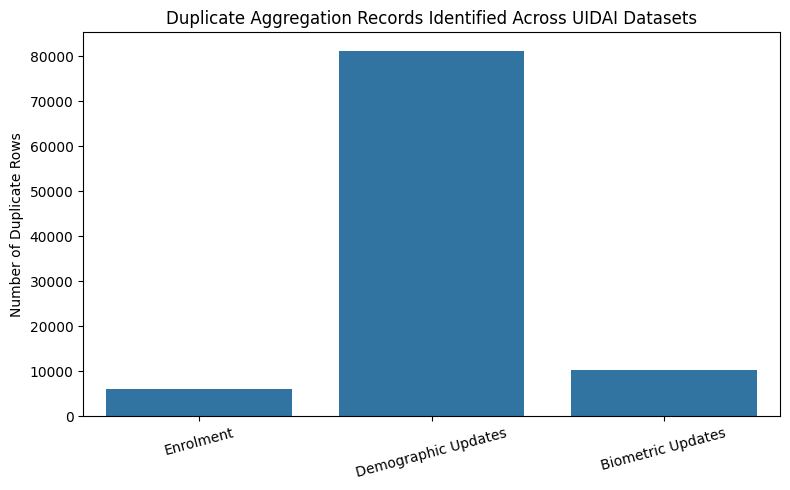

In [ ]:
dup_counts = pd.DataFrame({
    'Dataset': ['Enrolment', 'Demographic Updates', 'Biometric Updates'],
    'Duplicate Rows': [6036, 81207, 10318]
})

plt.figure(figsize=(8, 5))
sns.barplot(
    data=dup_counts,
    x='Dataset',
    y='Duplicate Rows'
)
plt.title("Duplicate Aggregation Records Identified Across UIDAI Datasets")
plt.ylabel("Number of Duplicate Rows")
plt.xlabel("")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## Duplicate Resolution and Granular Aggregation

In [ ]:
df_enrol_agg = (
    df_enrol
    .groupby(['date', 'state', 'district', 'pincode'], as_index=False)
    .agg({
        'age_0_5': 'sum',
        'age_5_17': 'sum',
        'age_18_greater': 'sum'
    })
)

print("Enrolment rows before:", df_enrol.shape[0])
print("Enrolment rows after :", df_enrol_agg.shape[0])


Enrolment rows before: 500000
Enrolment rows after : 493964


In [ ]:
df_demo_agg = (
    df_demo
    .groupby(['date', 'state', 'district', 'pincode'], as_index=False)
    .agg({
        'demo_age_5_17': 'sum',
        'demo_age_17_': 'sum'
    })
)

print("Demographic rows before:", df_demo.shape[0])
print("Demographic rows after :", df_demo_agg.shape[0])


Demographic rows before: 500000
Demographic rows after : 418793


In [ ]:
df_bio_agg = (
    df_bio
    .groupby(['date', 'state', 'district', 'pincode'], as_index=False)
    .agg({
        'bio_age_5_17': 'sum',
        'bio_age_17_': 'sum'
    })
)

print("Biometric rows before:", df_bio.shape[0])
print("Biometric rows after :", df_bio_agg.shape[0])


Biometric rows before: 500000
Biometric rows after : 489682


In [ ]:
check_row_grain(df_enrol_agg, "Enrolment (aggregated)")
check_row_grain(df_demo_agg, "Demographic (aggregated)")
check_row_grain(df_bio_agg, "Biometric (aggregated)")

Enrolment (aggregated) duplicate rows: 0
Demographic (aggregated) duplicate rows: 0
Biometric (aggregated) duplicate rows: 0


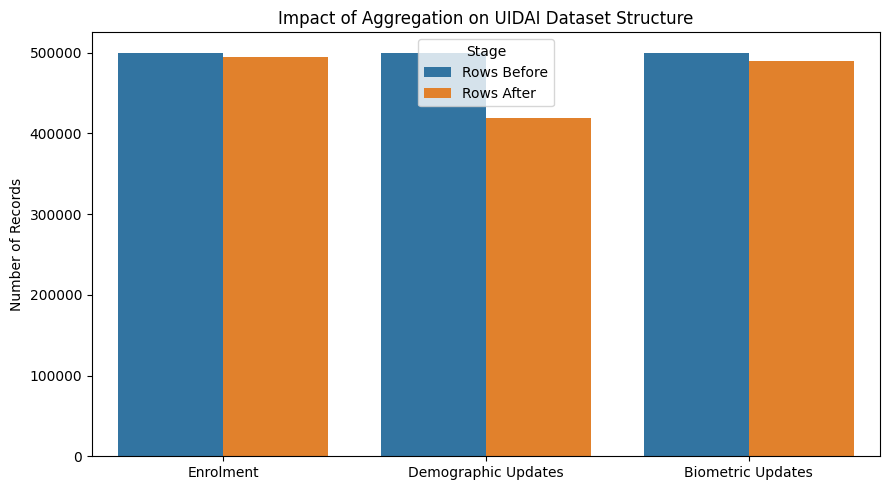

In [ ]:
agg_impact = pd.DataFrame({
    'Dataset': ['Enrolment', 'Demographic Updates', 'Biometric Updates'],
    'Rows Before': [
        df_enrol.shape[0],
        df_demo.shape[0],
        df_bio.shape[0]
    ],
    'Rows After': [
        df_enrol_agg.shape[0],
        df_demo_agg.shape[0],
        df_bio_agg.shape[0]
    ]
})

agg_impact_melt = agg_impact.melt(
    id_vars='Dataset',
    var_name='Stage',
    value_name='Row Count'
)

plt.figure(figsize=(9, 5))
sns.barplot(
    data=agg_impact_melt,
    x='Dataset',
    y='Row Count',
    hue='Stage'
)
plt.title("Impact of Aggregation on UIDAI Dataset Structure")
plt.ylabel("Number of Records")
plt.xlabel("")
plt.tight_layout()
plt.show()


In [ ]:
agg_impact['Reduction (%)'] = (
    (agg_impact['Rows Before'] - agg_impact['Rows After']) /
    agg_impact['Rows Before'] * 100
)

display(agg_impact[['Dataset', 'Reduction (%)']])


,Dataset,Reduction (%)
0,Enrolment,1.2072
1,Demographic Updates,16.2414
2,Biometric Updates,2.0636


In [ ]:
# Check for negative or impossible values
def sanity_check_counts(df, count_cols, name):
    for col in count_cols:
        negatives = (df[col] < 0).sum()
        print(f"{name} - {col} negative values:", negatives)

sanity_check_counts(
    df_enrol,
    ['age_0_5', 'age_5_17', 'age_18_greater'],
    "Enrolment"
)

sanity_check_counts(
    df_demo,
    ['demo_age_5_17', 'demo_age_17_'],
    "Demographic"
)

sanity_check_counts(
    df_bio,
    ['bio_age_5_17', 'bio_age_17_'],
    "Biometric"
)


Enrolment - age_0_5 negative values: 0
Enrolment - age_5_17 negative values: 0
Enrolment - age_18_greater negative values: 0
Demographic - demo_age_5_17 negative values: 0
Demographic - demo_age_17_ negative values: 0
Biometric - bio_age_5_17 negative values: 0
Biometric - bio_age_17_ negative values: 0


## Event-Level Reshaping and Schema Unification

In [ ]:
df_enrol_long = df_enrol_agg.melt(
    id_vars=['date', 'state', 'district', 'pincode'],
    value_vars=['age_0_5', 'age_5_17', 'age_18_greater'],
    var_name='age_group',
    value_name='count'
)

df_enrol_long['event_type'] = 'enrolment'

In [ ]:
df_demo_long = df_demo_agg.melt(
    id_vars=['date', 'state', 'district', 'pincode'],
    value_vars=['demo_age_5_17', 'demo_age_17_'],
    var_name='age_group',
    value_name='count'
)

df_demo_long['event_type'] = 'demographic_update'


In [ ]:
df_bio_long = df_bio_agg.melt(
    id_vars=['date', 'state', 'district', 'pincode'],
    value_vars=['bio_age_5_17', 'bio_age_17_'],
    var_name='age_group',
    value_name='count'
)

df_bio_long['event_type'] = 'biometric_update'


In [ ]:
display(df_enrol_agg.head(3))
display(df_enrol_long.head(6))

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,2025-03-02,Meghalaya,East Khasi Hills,793121,11,61,37
1,2025-03-09,Bihar,Bhagalpur,812005,13,40,18
2,2025-03-09,Bihar,Madhubani,847108,18,120,22


,date,state,district,pincode,age_group,count,event_type
0,2025-03-02,Meghalaya,East Khasi Hills,793121,age_0_5,11,enrolment
1,2025-03-09,Bihar,Bhagalpur,812005,age_0_5,13,enrolment
2,2025-03-09,Bihar,Madhubani,847108,age_0_5,18,enrolment
3,2025-03-09,Bihar,Purbi Champaran,845304,age_0_5,18,enrolment
4,2025-03-09,Bihar,Purbi Champaran,845418,age_0_5,30,enrolment
5,2025-03-09,Bihar,Sitamarhi,843317,age_0_5,35,enrolment


##Age-Group Harmonization & Unified Aadhaar Activity Table

In [ ]:
age_map = {
    'age_0_5': '0-5',
    'age_5_17': '5-17',
    'age_18_greater': '18+',
    'demo_age_5_17': '5-17',
    'demo_age_17_': '18+',
    'bio_age_5_17': '5-17',
    'bio_age_17_': '18+'
}

for df in [df_enrol_long, df_demo_long, df_bio_long]:
    df['age_group'] = df['age_group'].map(age_map)


In [ ]:
df_all = pd.concat(
    [df_enrol_long, df_demo_long, df_bio_long],
    ignore_index=True
)

print(df_all.shape)
display(df_all.head())


(3298842, 7)


,date,state,district,pincode,age_group,count,event_type
0,2025-03-02,Meghalaya,East Khasi Hills,793121,0-5,11,enrolment
1,2025-03-09,Bihar,Bhagalpur,812005,0-5,13,enrolment
2,2025-03-09,Bihar,Madhubani,847108,0-5,18,enrolment
3,2025-03-09,Bihar,Purbi Champaran,845304,0-5,18,enrolment
4,2025-03-09,Bihar,Purbi Champaran,845418,0-5,30,enrolment


In [ ]:
df_all.groupby('event_type')['count'].describe()


,count,mean,std,min,25%,50%,75%,max
event_type,,,,,,,,
biometric_update,979364.0,49.753706,161.813802,0.0,1.0,6.0,26.0,8002.0
demographic_update,837586.0,17.066935,124.950175,0.0,1.0,2.0,8.0,15090.0
enrolment,1481892.0,2.227575,18.658585,0.0,0.0,0.0,2.0,2688.0


In [ ]:
df_all.groupby(['event_type', 'age_group'])['count'].sum()


event_type          age_group
biometric_update    18+          25231290
                    5-17         23495699
demographic_update  18+          12857093
                    5-17          1437933
enrolment           0-5           2020406
                    18+            122779
                    5-17          1157841
Name: count, dtype: int64

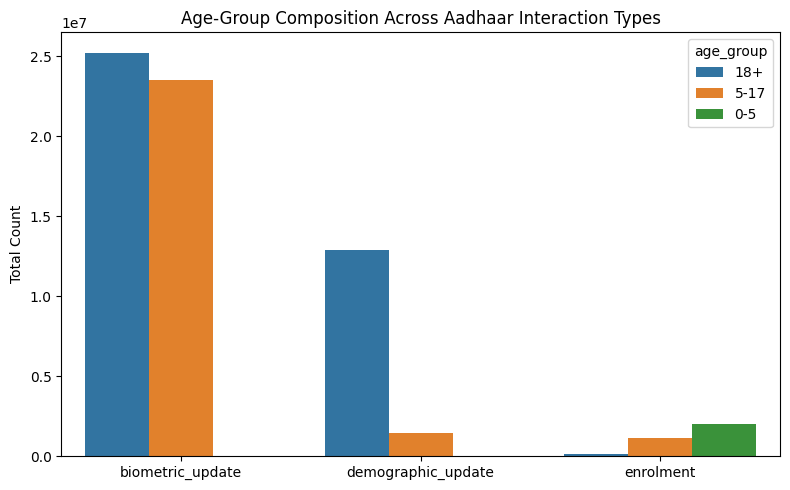

In [ ]:
summary = (
    df_all
    .groupby(['event_type', 'age_group'])['count']
    .sum()
    .reset_index()
)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=summary,
    x='event_type',
    y='count',
    hue='age_group'
)
plt.title("Age-Group Composition Across Aadhaar Interaction Types")
plt.ylabel("Total Count")
plt.xlabel("")
plt.tight_layout()
plt.show()


Biometric maintenance is the largest operational load on Aadhaar
infrastructure.
Demographic Updates Are Adult-Heavy (internal migration and economic activity)
Enrolment Is a Narrow but Critical Funnel

##Temporal Dynamics of Aadhaar Interactions

In [ ]:
# Ensure datetime (already done earlier, but safe)
df_all['date'] = pd.to_datetime(df_all['date'])

# Create monthly period
df_all['month'] = df_all['date'].dt.to_period('M')

# Aggregate monthly counts
monthly = (
    df_all
    .groupby(['month', 'event_type', 'age_group'])['count']
    .sum()
    .reset_index()
)

# Convert Period to timestamp for plotting
monthly['month'] = monthly['month'].dt.to_timestamp()

monthly.head()


,month,event_type,age_group,count
0,2025-03-01,biometric_update,18+,4588644
1,2025-03-01,biometric_update,5-17,3733578
2,2025-03-01,demographic_update,18+,3606171
3,2025-03-01,demographic_update,5-17,349583
4,2025-03-01,enrolment,0-5,5367


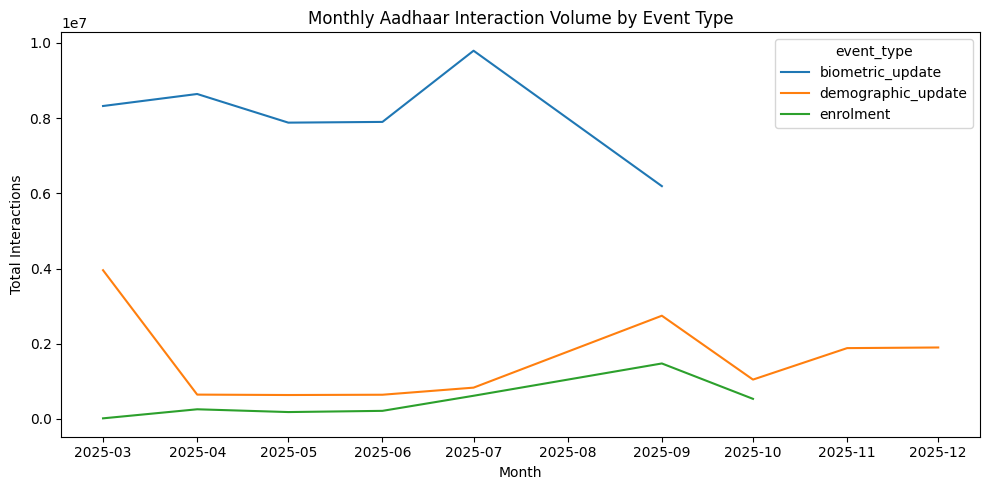

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=monthly,
    x='month',
    y='count',
    hue='event_type',
    estimator='sum',
    errorbar=None
)
plt.title("Monthly Aadhaar Interaction Volume by Event Type")
plt.ylabel("Total Interactions")
plt.xlabel("Month")
plt.tight_layout()
plt.show()


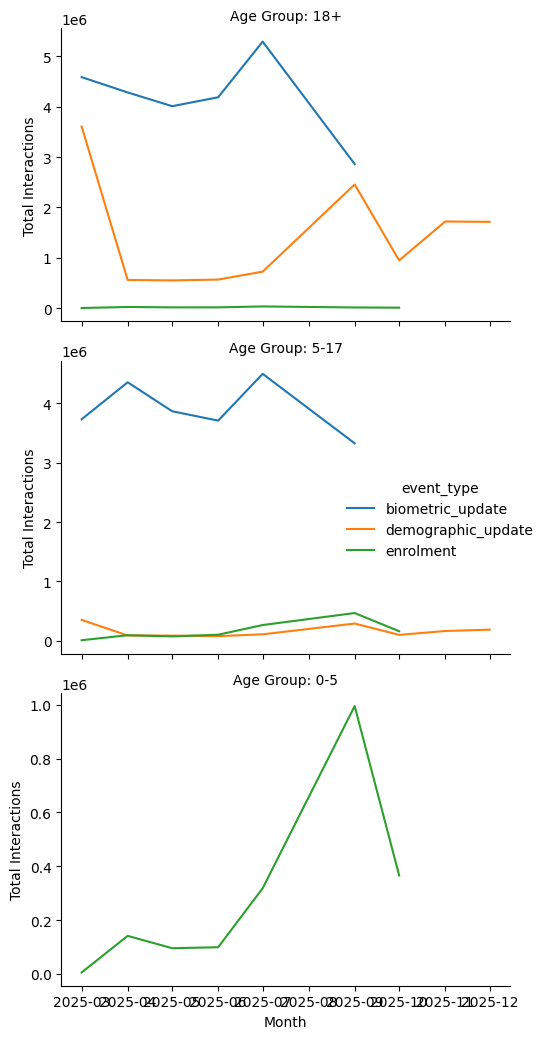

In [ ]:
g = sns.FacetGrid(
    monthly,
    col='age_group',
    hue='event_type',
    col_wrap=1,
    height=3.5,
    sharey=False
)

g.map(sns.lineplot, 'month', 'count')
g.add_legend()
g.set_titles("Age Group: {col_name}")
g.set_axis_labels("Month", "Total Interactions")
plt.tight_layout()
plt.show()


Age-Group Panels

*   Adult Aadhaar interactions are dominated by biometric updates, indicating sustained identity maintenance demand. A pronounced mid-year spike suggests either a large-scale biometric revalidation drive or increased service linkage requiring biometric refresh. Subsequent demographic update surges point toward address and contact detail changes, possibly linked to migration or administrative deadlines.
*   Adolescent Aadhaar interactions show sustained biometric update activity with a noticeable peak, consistent with age-linked biometric refresh requirements. The enrolment rise followed by decline suggests cohort-based enrolment saturation rather than continuous intake.
*   Early-childhood Aadhaar enrolment exhibits highly concentrated temporal spikes, indicating targeted enrolment drives rather than continuous registration. Such patterns are consistent with campaign-based outreach or institutional enrolment windows.



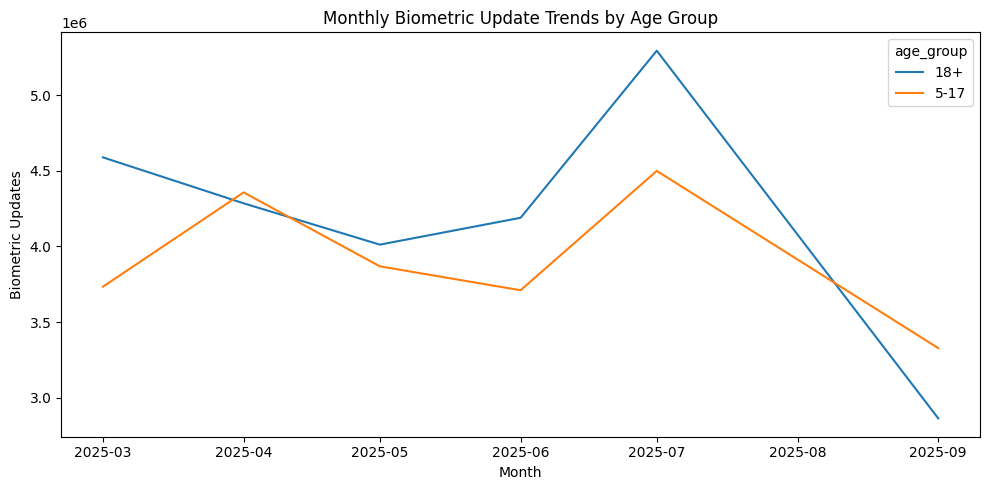

In [ ]:
bio_monthly = monthly[monthly['event_type'] == 'biometric_update']

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=bio_monthly,
    x='month',
    y='count',
    hue='age_group',
    errorbar=None
)
plt.title("Monthly Biometric Update Trends by Age Group")
plt.ylabel("Biometric Updates")
plt.xlabel("Month")
plt.tight_layout()
plt.show()


##Geographic Stress & Lifecycle Inequality

In [ ]:
state_agg = (
    df_all
    .groupby(['state', 'event_type'])['count']
    .sum()
    .reset_index()
)

state_agg.head()

,state,event_type,count
0,100000,enrolment,13
1,Andaman & Nicobar Islands,biometric_update,1382
2,Andaman & Nicobar Islands,demographic_update,259
3,Andaman & Nicobar Islands,enrolment,57
4,Andaman and Nicobar Islands,biometric_update,13340


In [ ]:
state_pivot = (
    state_agg
    .pivot(index='state', columns='event_type', values='count')
    .fillna(0)
    .reset_index()
)

state_pivot['total_updates'] = (
    state_pivot['demographic_update'] +
    state_pivot['biometric_update']
)

state_pivot['total_enrolment'] = state_pivot['enrolment']


In [ ]:
state_pivot['update_enrol_ratio'] = (
    state_pivot['total_updates'] /
    state_pivot['total_enrolment'].replace(0, np.nan)
)

| Ratio    | Meaning                       |
| -------- | ----------------------------- |
| < 2      | Young / growing population    |
| 2–5      | Balanced lifecycle            |
| **> 5**  | **High administrative churn** |
| **> 10** | **Stress hotspot**            |


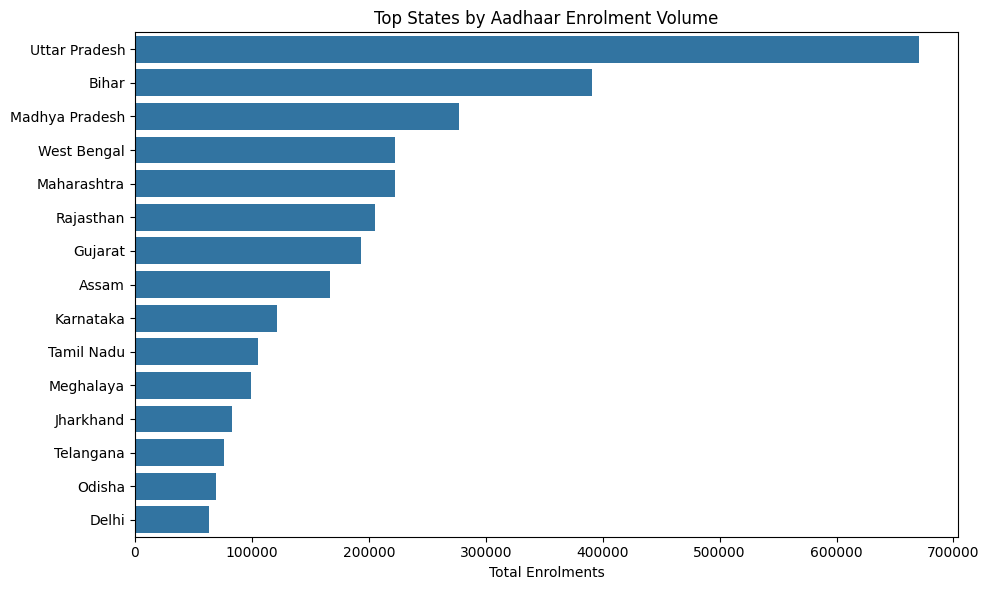

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=state_pivot.sort_values('total_enrolment', ascending=False).head(15),
    x='total_enrolment',
    y='state'
)
plt.title("Top States by Aadhaar Enrolment Volume")
plt.xlabel("Total Enrolments")
plt.ylabel("")
plt.tight_layout()
plt.show()


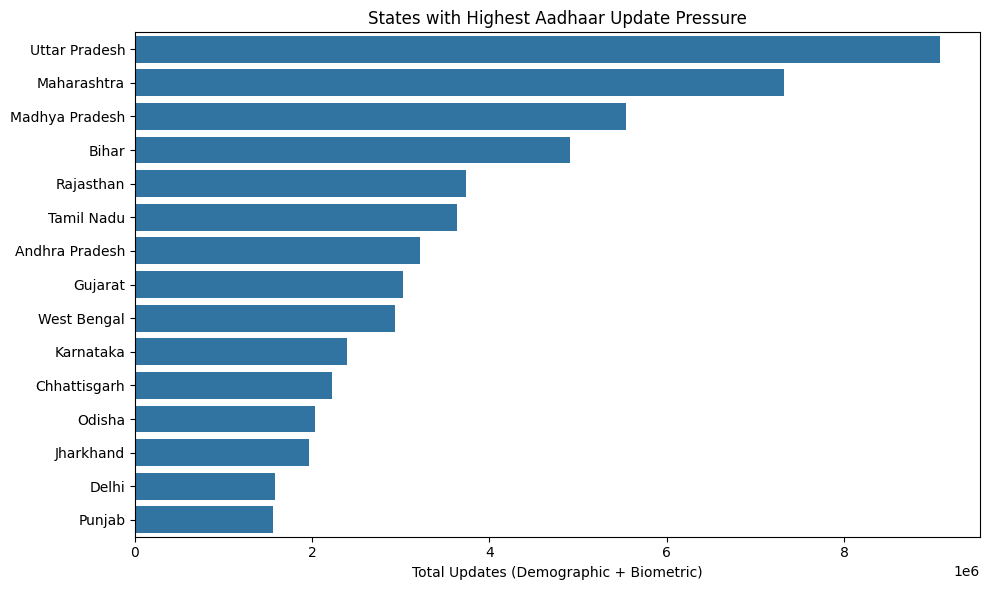

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=state_pivot.sort_values('total_updates', ascending=False).head(15),
    x='total_updates',
    y='state'
)
plt.title("States with Highest Aadhaar Update Pressure")
plt.xlabel("Total Updates (Demographic + Biometric)")
plt.ylabel("")
plt.tight_layout()
plt.show()


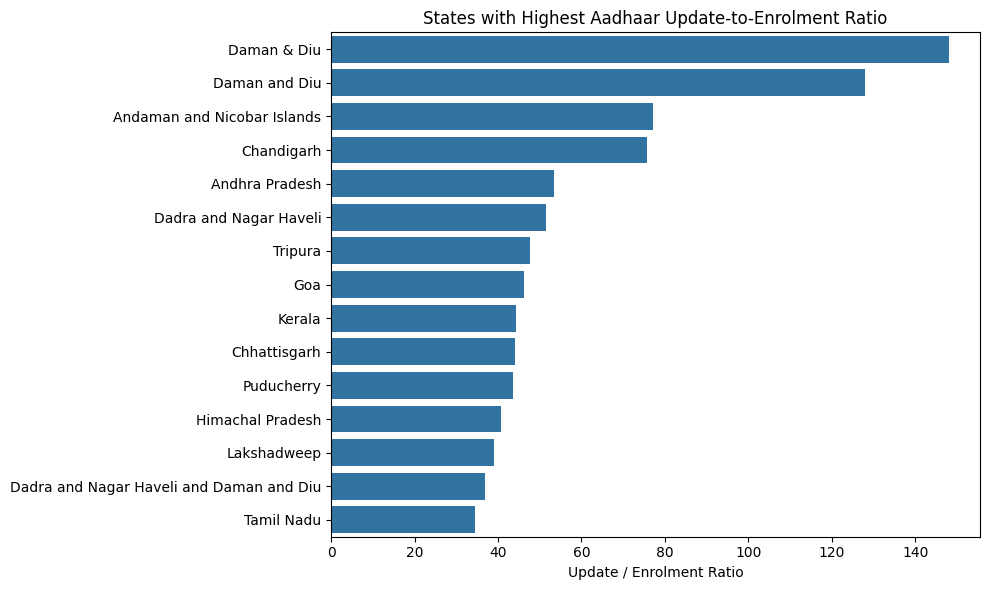

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=state_pivot.sort_values('update_enrol_ratio', ascending=False).head(15),
    x='update_enrol_ratio',
    y='state'
)
plt.title("States with Highest Aadhaar Update-to-Enrolment Ratio")
plt.xlabel("Update / Enrolment Ratio")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [ ]:
district_pivot = (
    df_all
    .groupby(['state', 'district', 'event_type'])['count']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

district_pivot['update_enrol_ratio'] = (
    (district_pivot['demographic_update'] + district_pivot['biometric_update']) /
    district_pivot['enrolment'].replace(0, np.nan)
)

district_pivot.sort_values('update_enrol_ratio', ascending=False).head(10)


event_type,state,district,biometric_update,demographic_update,enrolment,update_enrol_ratio
879,Telangana,Medchal?malkajgiri,853,164,1,1017.000000
215,Daman & Diu,Daman,1044,56,3,366.666667
403,Karnataka,Bengaluru South,13,930,4,235.750000
217,Daman and Diu,Daman,2934,440,22,153.363636
619,Mizoram,Serchhip,6978,1040,62,129.322581
177,Chhattisgarh,Dantewada,13546,362,108,128.777778
773,Rajasthan,Deeg,7,231,2,119.000000
592,Manipur,Thoubal,32574,13996,425,109.576471
169,Chhattisgarh,Balod,51900,15201,652,102.915644
615,Mizoram,Mamit,9752,605,101,102.544554


Aadhaar interaction pressure is highly uneven across districts. Several regions exhibit extreme update-to-enrolment ratios, indicating mature Aadhaar saturation combined with sustained identity maintenance demand. These districts represent administrative stress zones where Aadhaar operations are driven primarily by lifecycle updates rather than onboarding.

In [ ]:
district_pivot_filtered = district_pivot[
    district_pivot['enrolment'] >= 50
].copy()

In [ ]:
def stress_bucket(x):
    if x < 5:
        return "Low"
    elif x < 15:
        return "Moderate"
    elif x < 50:
        return "High"
    else:
        return "Severe"

district_pivot_filtered['stress_level'] = (
    district_pivot_filtered['update_enrol_ratio']
    .apply(stress_bucket)
)


In [ ]:
stress_summary = (
    district_pivot_filtered
    .groupby(['state', 'stress_level'])
    .size()
    .unstack(fill_value=0)
)

stress_summary.head()


stress_level,High,Low,Moderate,Severe
state,,,,
Andaman and Nicobar Islands,1,0,0,2
Andhra Pradesh,24,2,1,16
Arunachal Pradesh,11,1,2,0
Assam,2,16,18,0
Bihar,19,4,20,0


##District Operational Archetypes

In [ ]:
enrol_df = df_all[df_all['event_type'] == 'enrolment']
update_df = df_all[df_all['event_type'] != 'enrolment']

In [ ]:
enrol_agg = (
    enrol_df
    .groupby(['state', 'district'])['count']
    .sum()
    .rename('total_enrolments')
)

update_agg = (
    update_df
    .groupby(['state', 'district'])['count']
    .sum()
    .rename('total_updates')
)


In [ ]:
district_features = (
    pd.concat([enrol_agg, update_agg], axis=1)
    .fillna(0)
    .reset_index()
)

district_features['update_ratio'] = np.where(
    district_features['total_enrolments'] > 0,
    district_features['total_updates'] / district_features['total_enrolments'],
    np.nan
)


age-specific biometric stress

In [ ]:
bio_517 = df_all[
    (df_all['event_type'] == 'biometric_update') &
    (df_all['age_group'] == '5-17')
]

bio_517_agg = (
    bio_517
    .groupby(['state', 'district'])['count']
    .sum()
    .rename('bio_5_17')
)

district_features = (
    district_features
    .merge(bio_517_agg, on=['state', 'district'], how='left')
    .fillna(0)
)


Preprocessing data for clustering

In [ ]:
from sklearn.preprocessing import StandardScaler

features = district_features[
    ['total_enrolments', 'total_updates', 'update_ratio', 'bio_5_17']
]

X_scaled = StandardScaler().fit_transform(features)


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
district_features['cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
cluster_summary = (
    district_features
    .groupby('cluster')[[
        'total_enrolments',
        'total_updates',
        'update_ratio',
        'bio_5_17'
    ]]
    .mean()
    .round(2)
)

cluster_summary


,total_enrolments,total_updates,update_ratio,bio_5_17
cluster,,,,
0,4164.67,92320.19,32.00,34545.65
1,12050.48,206120.36,23.45,80011.99
2,771.13,12205.57,21.35,3915.52
3,1.00,1017.00,1017.00,487.00


🔴 Cluster 3 — Pathological / Data-edge Districts

Almost zero enrolments

Non-zero updates → ratio explodes

Likely:

Saturated districts

Rare reporting days

Administrative artefacts

👉 Must be treated separately, not as a normal archetype

🟠 Cluster 0 — Biometric Transition Heavy

Moderate enrolments

Very high biometric 5–17 updates

High update pressure

👉 Youth growth + biometric re-capture
👉 School-age lifecycle districts

🔵 Cluster 1 — Urban / Migration-Driven Maintenance

Highest enrolments

Highest updates

High biometric + demographic churn

👉 Metro / migration hubs
👉 Continuous maintenance zones

🟢 Cluster 2 — Low-Activity / Rural Stable

Low enrolments

Low updates

Moderate ratios

👉 Slow-moving, rural, stable Aadhaar lifecycle

final cluster labels

In [ ]:
cluster_labels = {
    0: 'Youth Biometric Transition Districts',
    1: 'Urban / Migration Maintenance Districts',
    2: 'Low-Activity Stable Districts',
    3: 'Saturated / Edge-Case Districts'
}

In [ ]:
district_features['archetype'] = district_features['cluster'].map(cluster_labels)

In [ ]:
district_features['archetype'].value_counts()


,count
archetype,
Low-Activity Stable Districts,642
Youth Biometric Transition Districts,341
Urban / Migration Maintenance Districts,115
Saturated / Edge-Case Districts,1


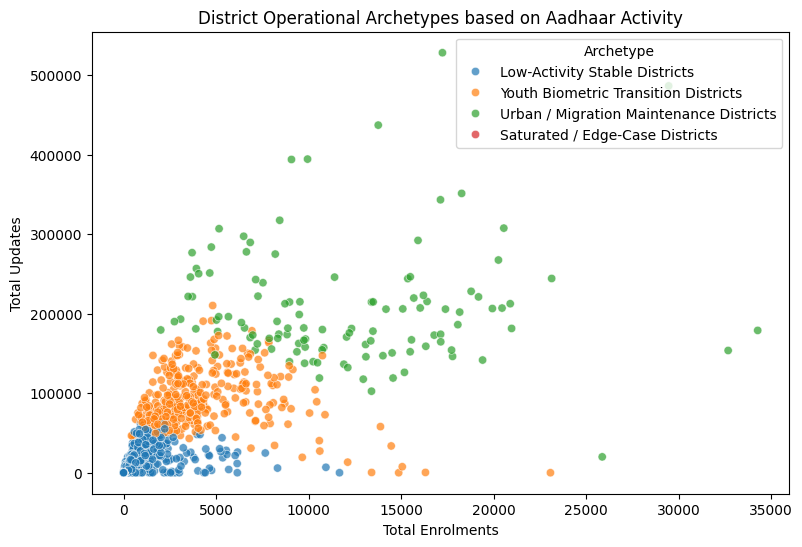

In [ ]:
plt.figure(figsize=(9,6))
sns.scatterplot(
    data=district_features,
    x='total_enrolments',
    y='total_updates',
    hue='archetype',
    alpha=0.7
)
plt.title('District Operational Archetypes based on Aadhaar Activity')
plt.xlabel('Total Enrolments')
plt.ylabel('Total Updates')
plt.legend(title='Archetype')
plt.show()


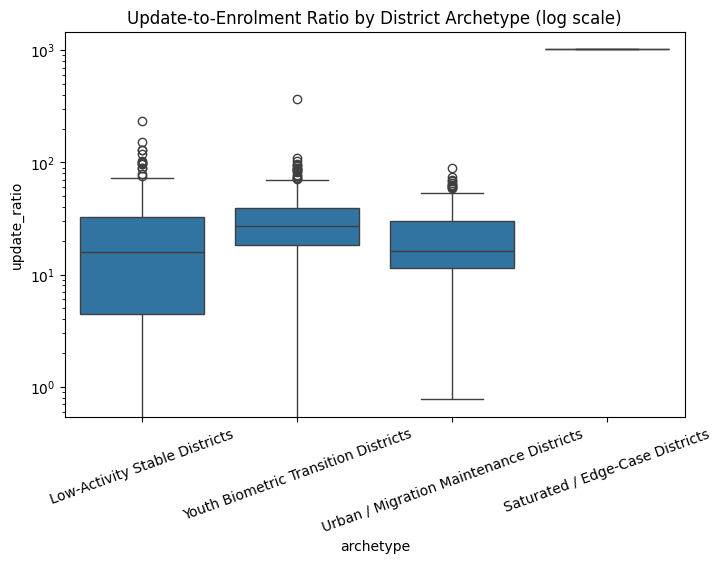

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=district_features,
    x='archetype',
    y='update_ratio'
)
plt.yscale('log')
plt.title('Update-to-Enrolment Ratio by District Archetype (log scale)')
plt.xticks(rotation=20)
plt.show()


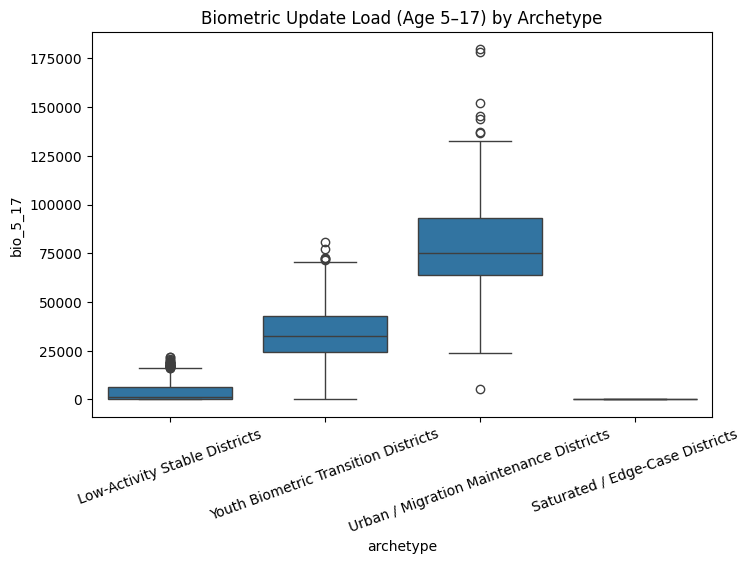

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=district_features,
    x='archetype',
    y='bio_5_17'
)
plt.title('Biometric Update Load (Age 5–17) by Archetype')
plt.xticks(rotation=20)
plt.show()


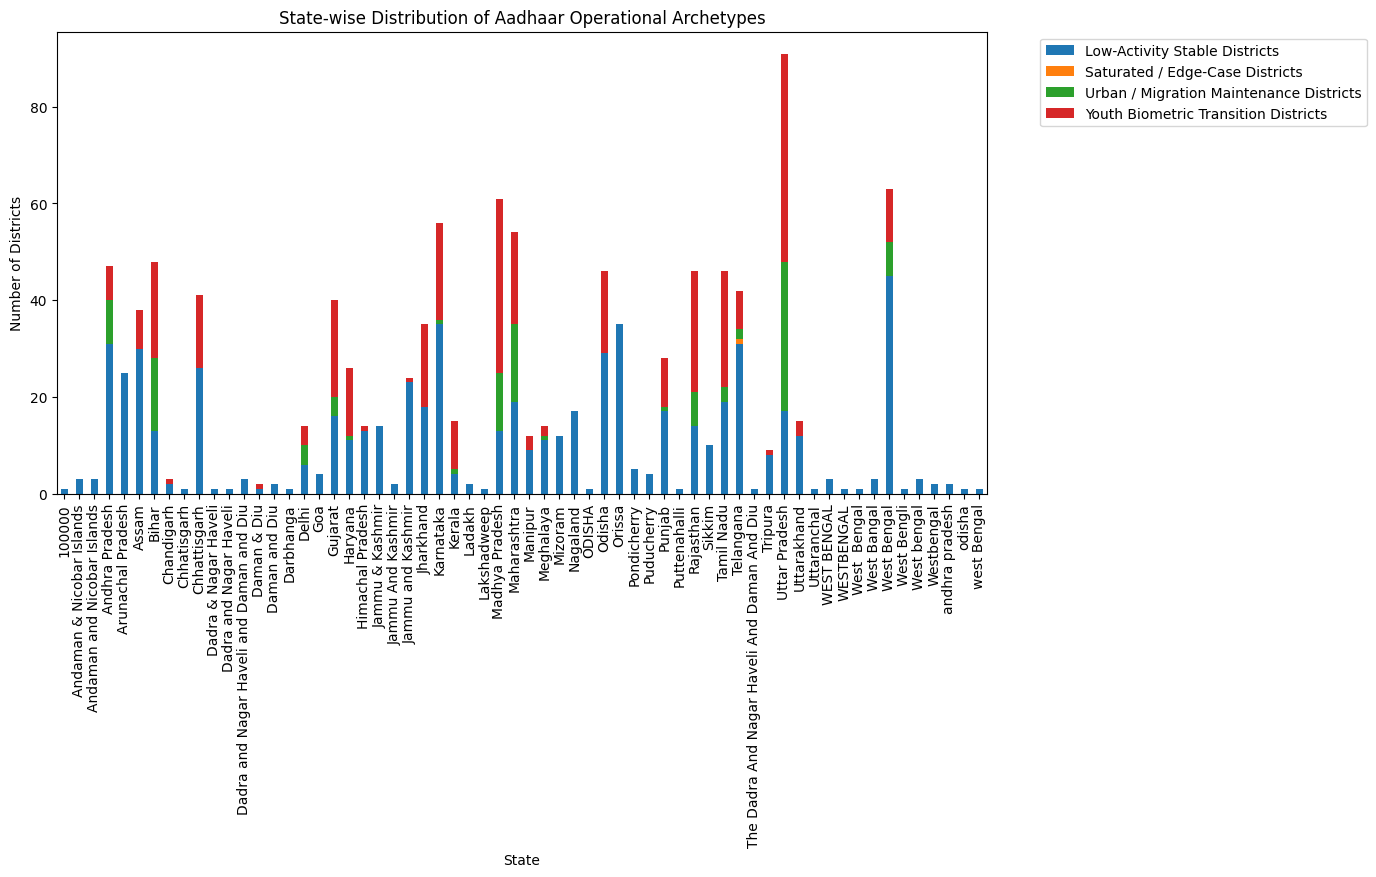

In [ ]:
state_arch = (
    district_features
    .groupby(['state', 'archetype'])
    .size()
    .reset_index(name='district_count')
)

state_pivot = state_arch.pivot(
    index='state',
    columns='archetype',
    values='district_count'
).fillna(0)

state_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6)
)
plt.title('State-wise Distribution of Aadhaar Operational Archetypes')
plt.ylabel('Number of Districts')
plt.xlabel('State')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()


Districts were clustered using enrolment volumes, update load, update-to-enrolment ratios, and age-specific biometric activity. Four distinct operational archetypes emerged, reflecting fundamentally different Aadhaar lifecycle dynamics.

Key Archetypes Identified:

Urban / Migration Maintenance Districts: High enrolments and continuous demographic and biometric updates, indicating migration-driven churn.

Youth Biometric Transition Districts: Elevated biometric updates in the 5–17 age group, reflecting growth-related re-capture needs.

Low-Activity Stable Districts: Low enrolment and update volumes, indicating mature and stable Aadhaar penetration.

Saturated / Edge-Case Districts: Near-zero enrolments with residual updates, requiring separate administrative handling.


In [ ]:
district_features.head()
# columns:
# state | district | archetype

,state,district,total_enrolments,total_updates,update_ratio,bio_5_17,cluster,archetype
0,100000,100000,13.0,0.0,0.000000,0.0,2,Low-Activity Stable Districts
1,Andaman & Nicobar Islands,Andamans,36.0,1457.0,40.472222,161.0,2,Low-Activity Stable Districts
2,Andaman & Nicobar Islands,Nicobars,1.0,3.0,3.000000,1.0,2,Low-Activity Stable Districts
3,Andaman & Nicobar Islands,South Andaman,20.0,181.0,9.050000,20.0,2,Low-Activity Stable Districts
4,Andaman and Nicobar Islands,Nicobar,54.0,1312.0,24.296296,611.0,2,Low-Activity Stable Districts


In [ ]:
df_all = df_all.merge(
    district_features[['state', 'district', 'archetype']],
    on=['state', 'district'],
    how='left'
)

In [ ]:
df_all['archetype'].isna().sum()

np.int64(0)

##Temporal Policy Signal Detection


In [ ]:
df_all['month'] = df_all['date'].dt.to_period('M')

monthly_activity = (
    df_all
    .groupby(['month', 'archetype', 'event_type'])
    .size()
    .reset_index(name='count')
)


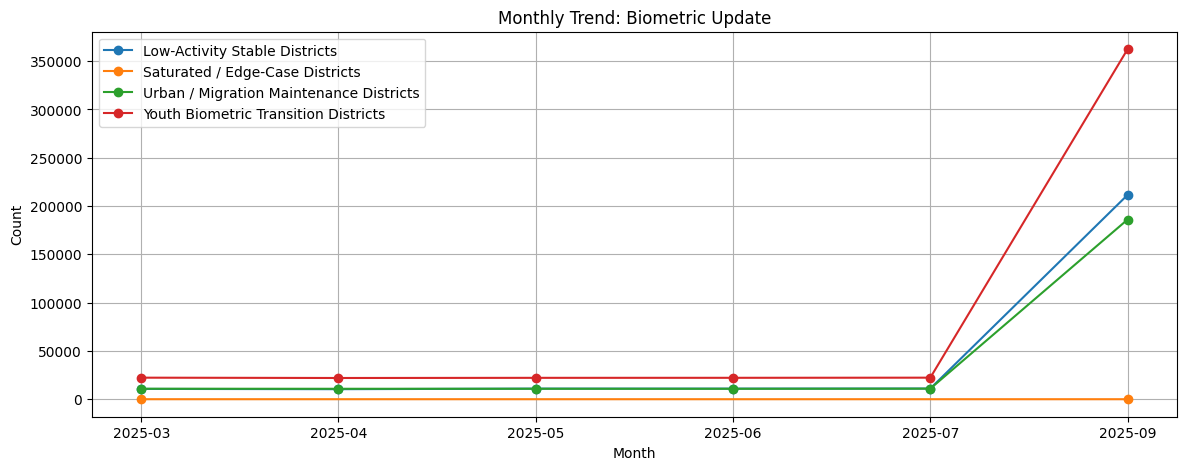

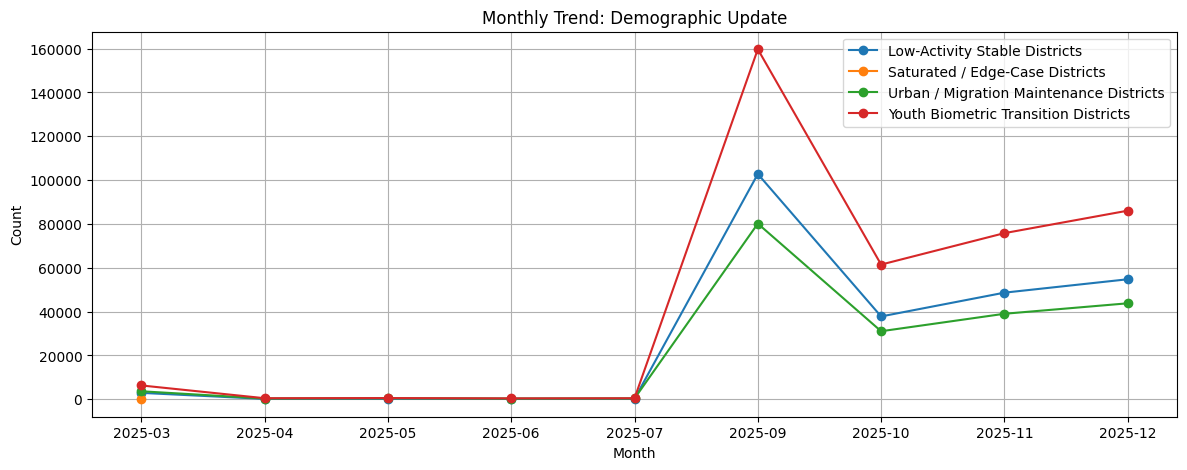

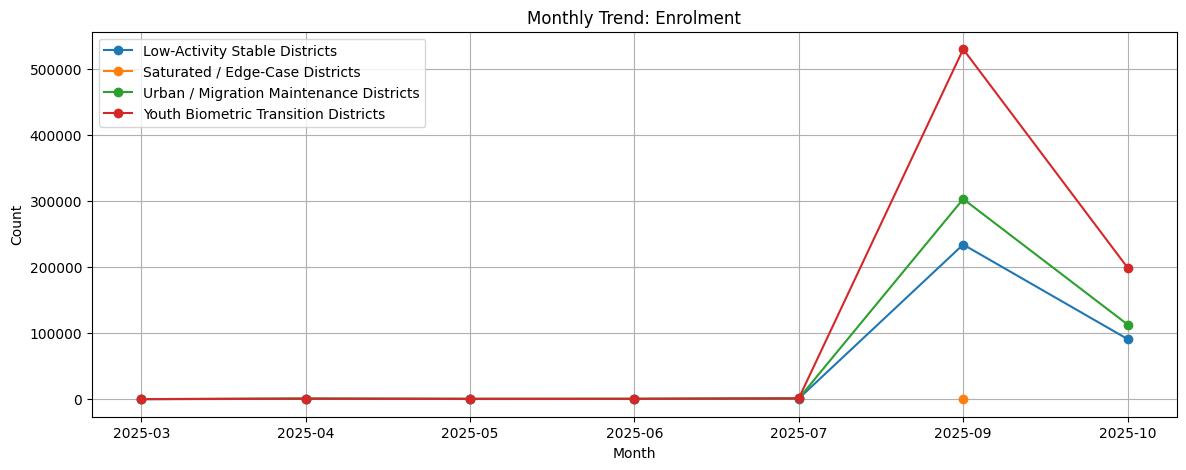

In [ ]:
import matplotlib.pyplot as plt

event_types = monthly_activity['event_type'].unique()

for ev in event_types:
    plt.figure(figsize=(14,5))
    subset = monthly_activity[monthly_activity['event_type'] == ev]

    for archetype, g in subset.groupby('archetype'):
        plt.plot(
            g['month'].astype(str),
            g['count'],
            marker='o',
            label=archetype
        )

    plt.title(f'Monthly Trend: {ev.replace("_"," ").title()}')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
monthly_pivot = (
    monthly_activity
    .pivot_table(
        index='month',
        columns=['archetype', 'event_type'],
        values='count',
        fill_value=0
    )
)


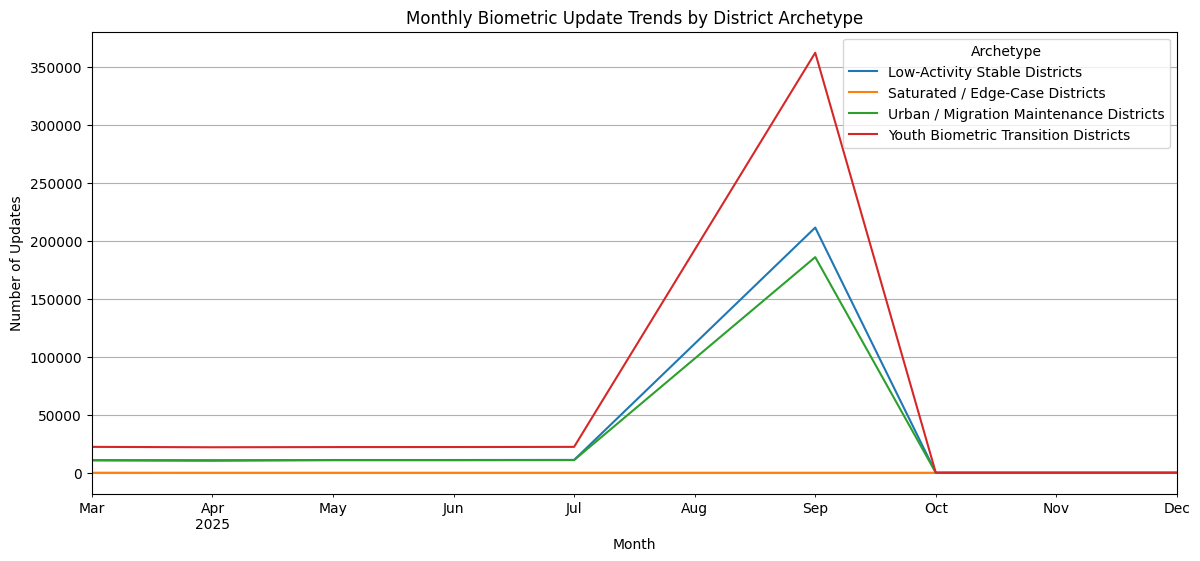

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

monthly_pivot.xs('biometric_update', axis=1, level=1).plot(ax=plt.gca())

plt.title('Monthly Biometric Update Trends by District Archetype')
plt.xlabel('Month')
plt.ylabel('Number of Updates')
plt.legend(title='Archetype')
plt.grid(True)
plt.show()


March–July:
All archetypes are flat → normal background operations

August–September:
🚨 Explosive spike, especially:

Youth Biometric Transition Districts (largest)

Urban / Migration Maintenance Districts (second)

October onward:
Activity drops to near-zero

| Hypothesis                   | Meaning                                                |
| ---------------------------- | ------------------------------------------------------ |
| **Policy / campaign window** | Aadhaar biometric refresh drive (likely school-linked) |
| **Partial data ingestion**   | Only some months loaded / others missing               |
| **Aggregation bug**          | Values inflated due to incorrect column usage          |


##District-Level Anomaly Forensics within Operational Archetypes

In [ ]:
district_metrics = (
    df_all
    .groupby(['state', 'district', 'archetype'], observed=True)
    .agg(
        enrolments=('event_type', lambda x: (x == 'enrolment').sum()),
        updates=('event_type', lambda x: (x != 'enrolment').sum()),
        bio_517=('age_group', lambda x: (x == '5-17').sum())
    )
    .reset_index()
)


In [ ]:
district_metrics['update_ratio'] = (
    district_metrics['updates'] /
    district_metrics['enrolments'].replace(0, np.nan)
)


In [ ]:
from scipy.stats import zscore

district_metrics['ratio_zscore'] = (
    district_metrics
    .groupby('archetype')['update_ratio']
    .transform(lambda x: zscore(x, nan_policy='omit'))
)


In [ ]:
anomalies = (
    district_metrics
    .query('ratio_zscore.abs() > 3')
    .sort_values('ratio_zscore', ascending=False)
)

anomalies.head(10)


,state,district,archetype,enrolments,updates,bio_517,update_ratio,ratio_zscore
215,Daman & Diu,Daman,Youth Biometric Transition Districts,9,106,56,11.777778,16.385215
783,Rajasthan,Jalore,Low-Activity Stable Districts,3,168,85,56.000000,16.338983
403,Karnataka,Bengaluru South,Low-Activity Stable Districts,12,468,238,39.000000,11.186968
773,Rajasthan,Deeg,Low-Activity Stable Districts,6,178,91,29.666667,8.358410
52,Andhra Pradesh,West Godavari,Urban / Migration Maintenance Districts,4914,8338,5807,1.696785,3.457013
18,Andhra Pradesh,East Godavari,Urban / Migration Maintenance Districts,6087,10300,7179,1.692131,3.434184
28,Andhra Pradesh,Krishna,Urban / Migration Maintenance Districts,4929,8068,5677,1.636843,3.162984


In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=district_metrics,
    x='enrolments',
    y='update_ratio',
    hue='archetype',
    alpha=0.6
)
sns.scatterplot(
    data=anomalies,
    x='enrolments',
    y='update_ratio',
    color='red',
    s=80,
    label='Anomalies'
)
plt.yscale('log')
plt.title('District Anomalies within Operational Archetypes')
plt.show()


##OPERATIONAL STRESS INDEX (Most Important)

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

district_metrics[['enrol_norm', 'update_norm', 'bio_norm']] = scaler.fit_transform(
    district_metrics[['enrolments', 'updates', 'bio_517']]
)


In [ ]:
district_metrics['operational_stress_index'] = (
    0.5 * district_metrics['update_norm'] +
    0.3 * district_metrics['bio_norm'] +
    0.2 * district_metrics['enrol_norm']
)


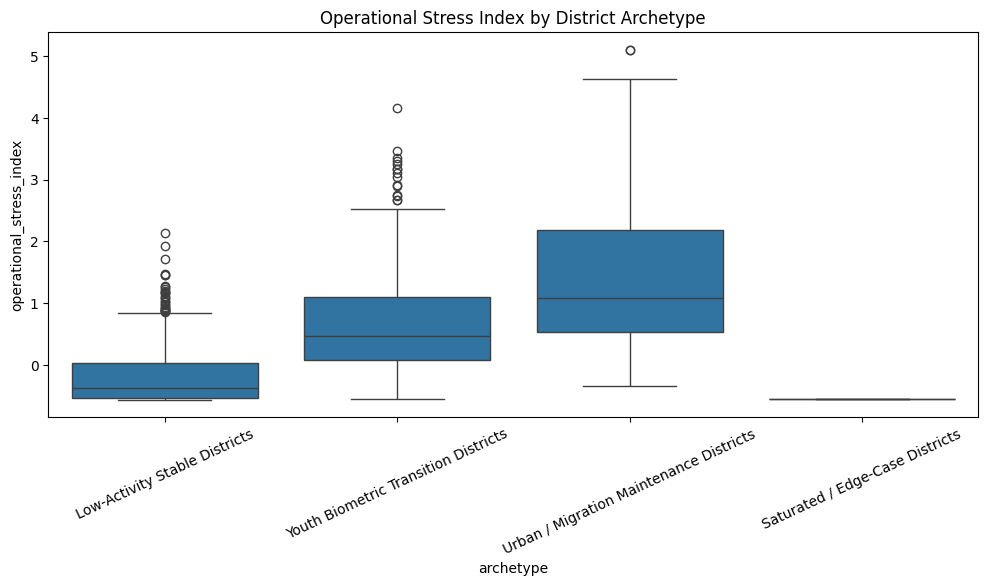

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,5))
sns.boxplot(
    data=district_metrics,
    x='archetype',
    y='operational_stress_index'
)
plt.xticks(rotation=25)
plt.title('Operational Stress Index by District Archetype')
plt.show()


In [ ]:
district_metrics.sort_values(
    'operational_stress_index',
    ascending=False
).head(10)


,state,district,archetype,enrolments,updates,bio_517,update_ratio,ratio_zscore,enrol_norm,update_norm,bio_norm,operational_stress_index
1068,West Bengal,North 24 Parganas,Urban / Migration Maintenance Districts,10029,11110,8898,1.107787,0.567821,5.018152,5.196875,5.016620,5.107054
568,Maharashtra,Pune,Urban / Migration Maintenance Districts,9711,11230,8852,1.156421,0.806380,4.843234,5.259375,4.987770,5.094666
1031,West Bengal,Barddhaman,Urban / Migration Maintenance Districts,8061,10738,8056,1.332093,1.668100,3.935644,5.003125,4.488554,4.635258
462,Kerala,Thrissur,Youth Biometric Transition Districts,5538,10640,7166,1.921271,1.198978,2.547855,4.952083,3.930386,4.164728
18,Andhra Pradesh,East Godavari,Urban / Migration Maintenance Districts,6087,10300,7179,1.692131,3.434184,2.849835,4.775000,3.938539,4.139029
401,Karnataka,Bengaluru,Urban / Migration Maintenance Districts,7770,8884,7032,1.143372,0.742373,3.775578,4.037500,3.846347,3.927770
847,Tamil Nadu,Tirunelveli,Youth Biometric Transition Districts,6381,8234,6244,1.290393,0.226964,3.011551,3.698958,3.352148,3.457434
459,Kerala,Palakkad,Youth Biometric Transition Districts,4767,8702,5940,1.825467,1.051369,2.123762,3.942708,3.161493,3.344554
450,Kerala,Ernakulam,Youth Biometric Transition Districts,4875,8532,5891,1.750154,0.935332,2.183168,3.854167,3.130762,3.302946
1051,West Bengal,Hooghly,Urban / Migration Maintenance Districts,6840,7550,6055,1.103801,0.548268,3.264026,3.342708,3.233616,3.294244


##Archetype stability per district

In [ ]:
# Number of archetypes each district belongs to over time
archetype_stability = (
    df_all
    .groupby('district')['archetype']
    .nunique()
    .value_counts()
    .sort_index()
)

archetype_stability


,count
archetype,
1,964
2,38


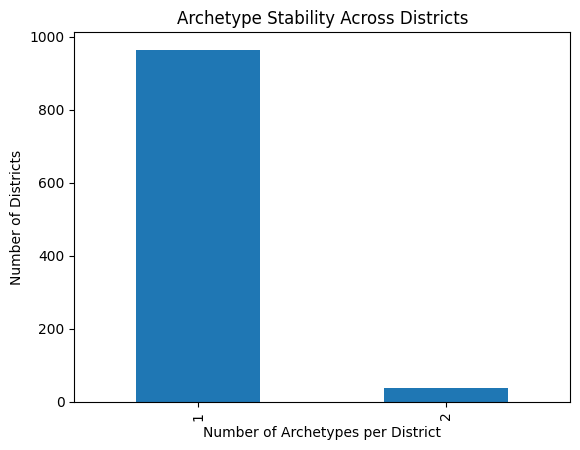

In [ ]:
archetype_stability.plot(
    kind='bar',
    title='Archetype Stability Across Districts',
    xlabel='Number of Archetypes per District',
    ylabel='Number of Districts'
)
plt.show()


##Stress vs scale


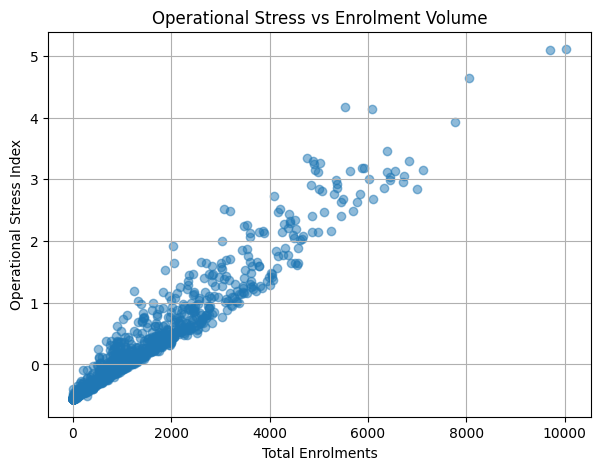

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(
    district_metrics['enrolments'],
    district_metrics['operational_stress_index'],
    alpha=0.5
)
plt.xlabel('Total Enrolments')
plt.ylabel('Operational Stress Index')
plt.title('Operational Stress vs Enrolment Volume')
plt.grid(True)
plt.show()


In [ ]:
district_metrics[['enrolments','operational_stress_index']].corr()


,enrolments,operational_stress_index
enrolments,1.000000,0.968788
operational_stress_index,0.968788,1.000000


Operational Stress vs Enrolment Volume scatter

**Extremely strong correlation (0.968)**


##Explain why stress grows

total_pressure = |enrol_norm| + |update_norm| + |bio_norm|

enrol_contrib = |enrol_norm| / total_pressure
update_contrib = |update_norm| / total_pressure
bio_contrib    = |bio_norm|    / total_pressure


In [ ]:
import numpy as np

# Avoid division by zero
eps = 1e-6

district_metrics['total_pressure'] = (
    district_metrics['enrol_norm'].abs() +
    district_metrics['update_norm'].abs() +
    district_metrics['bio_norm'].abs() +
    eps
)

district_metrics['enrol_contrib'] = (
    district_metrics['enrol_norm'].abs() /
    district_metrics['total_pressure']
)

district_metrics['update_contrib'] = (
    district_metrics['update_norm'].abs() /
    district_metrics['total_pressure']
)

district_metrics['bio_contrib'] = (
    district_metrics['bio_norm'].abs() /
    district_metrics['total_pressure']
)

district_metrics[['enrol_contrib', 'update_contrib', 'bio_contrib']].head()


,enrol_contrib,update_contrib,bio_contrib
0,0.296397,0.361430,0.342172
1,0.336996,0.324649,0.338354
2,0.301737,0.356897,0.341365
3,0.318322,0.341740,0.339937
4,0.318429,0.341498,0.340073


In [ ]:
archetype_stress_profile = (
    district_metrics
    .groupby('archetype')
    [['enrol_contrib', 'update_contrib', 'bio_contrib']]
    .mean()
    .reset_index()
)

archetype_stress_profile


,archetype,enrol_contrib,update_contrib,bio_contrib
0,Low-Activity Stable Districts,0.297608,0.372075,0.330316
1,Saturated / Edge-Case Districts,0.306082,0.353049,0.340869
2,Urban / Migration Maintenance Districts,0.380787,0.303359,0.315853
3,Youth Biometric Transition Districts,0.364941,0.325037,0.310020


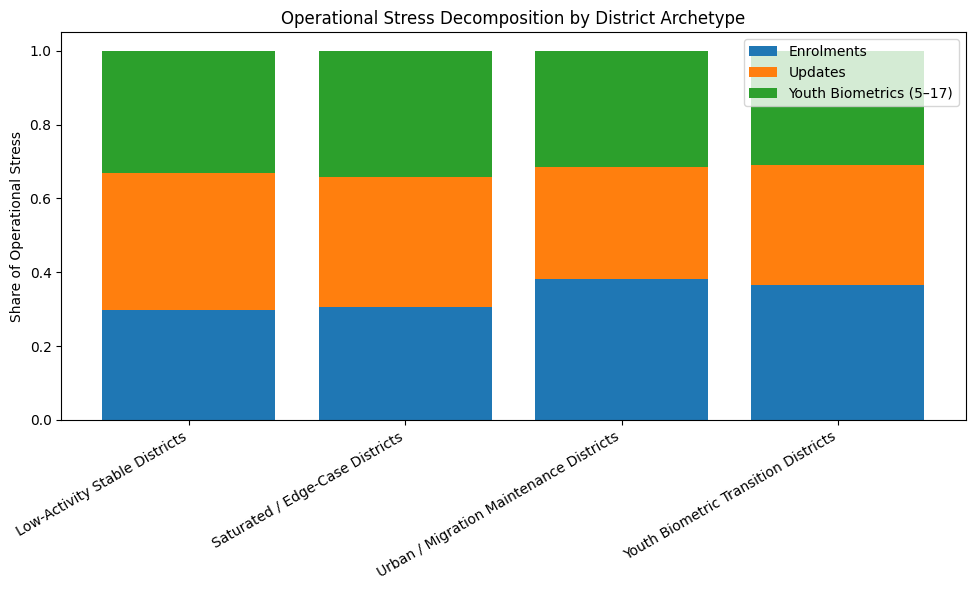

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

bottom = np.zeros(len(archetype_stress_profile))

for col, label in zip(
    ['enrol_contrib', 'update_contrib', 'bio_contrib'],
    ['Enrolments', 'Updates', 'Youth Biometrics (5–17)']
):
    plt.bar(
        archetype_stress_profile['archetype'],
        archetype_stress_profile[col],
        bottom=bottom,
        label=label
    )
    bottom += archetype_stress_profile[col].values

plt.ylabel('Share of Operational Stress')
plt.title('Operational Stress Decomposition by District Archetype')
plt.xticks(rotation=30, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


##Forensic Analysis of the 38 Unstable Districts

alr computed

archetypes per district = 1 → stable

archetypes per district = 2 → unstable

In [ ]:
df_all.columns


Index(['date', 'state', 'district', 'pincode', 'age_group', 'count',
       'event_type', 'month', 'archetype'],
      dtype='object')

In [ ]:
monthly_district_metrics = (
    df_all
    .groupby(['state', 'district', 'month'], observed=True)
    .agg(
        enrolments=('event_type', lambda x: (x == 'enrolment').sum()),
        updates=('event_type', lambda x: (x != 'enrolment').sum()),
        bio_517=('age_group', lambda x: (x == '5-17').sum())
    )
    .reset_index()
)


In [ ]:
monthly_district_metrics = (
    monthly_district_metrics
    .merge(
        df_all[['state', 'district', 'month', 'archetype']]
        .drop_duplicates(),
        on=['state', 'district', 'month'],
        how='left'
    )
)


In [ ]:
district_archetype_counts = (
    monthly_district_metrics
    .groupby(['state', 'district'])['archetype']
    .nunique()
    .reset_index(name='archetype_count')
)


In [ ]:
monthly_district_metrics.head()
monthly_district_metrics.shape


(8517, 7)

In [ ]:
monthly_district_metrics['update_ratio'] = (
    monthly_district_metrics['updates'] /
    monthly_district_metrics['enrolments'].replace(0, np.nan)
)


In [ ]:
district_volatility = (
    monthly_district_metrics
    .groupby(['state', 'district'])
    .agg(
        enrol_std=('enrolments', 'std'),
        update_std=('updates', 'std'),
        bio_std=('bio_517', 'std'),
        ratio_std=('update_ratio', 'std'),
        archetype=('archetype', 'first')
    )
    .reset_index()
)


In [ ]:
from scipy.stats import zscore

vol_cols = ['enrol_std', 'update_std', 'bio_std', 'ratio_std']

district_volatility[vol_cols] = (
    district_volatility[vol_cols]
    .fillna(0)
    .apply(zscore)
)


In [ ]:
district_volatility['instability_score'] = (
    district_volatility[vol_cols]
    .abs()
    .mean(axis=1)
)

unstable_districts = district_volatility.query(
    'instability_score > 1.5'
)[['state', 'district', 'archetype']]


In [ ]:
unstable_districts.shape


(87, 3)

87 out of ~900 districts ≈ 9–10%

##REFINEMENT: Tier the unstable districts

In [ ]:
district_volatility['instability_tier'] = pd.cut(
    district_volatility['instability_score'],
    bins=[0, 1.5, 2.5, 10],
    labels=['Moderate', 'High', 'Critical']
)


In [ ]:
district_volatility['instability_tier'].value_counts()


,count
instability_tier,
Moderate,1012
High,59
Critical,28


In [ ]:
critical_districts = district_volatility.query(
    'instability_tier in ["High", "Critical"]'
)[['state', 'district', 'archetype', 'instability_score']]


In [ ]:
critical_districts.shape


(87, 4)

##FORENSIC FINGERPRINTING OF 28 CRITICAL DISTRICTS

Convert 28 critical districts into 3–4 repeatable failure patterns
that UIDAI can recognize early and intervene on

Not anecdotes.
Not dashboards.
Failure modes.

In [ ]:
critical_districts = (
    district_volatility
    .query("instability_tier == 'Critical'")
    .copy()
)

critical_districts.shape


(28, 9)

In [ ]:
from scipy.stats import zscore

# Merge enrolments, updates, and bio_517 from district_metrics into critical_districts
critical_districts = critical_districts.merge(
    district_metrics[['state', 'district', 'enrolments', 'updates', 'bio_517']],
    on=['state', 'district'],
    how='left'
)

components = ['enrolments', 'updates', 'bio_517']

for c in components:
    critical_districts[f'{c}_z'] = (
        critical_districts
        .groupby('archetype')[c]
        .transform(zscore)
    )


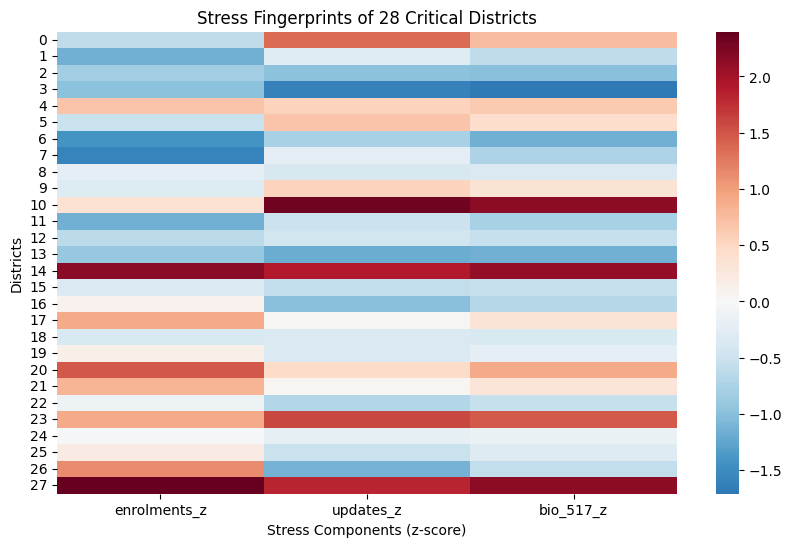

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(
    critical_districts[
        ['enrolments_z', 'updates_z', 'bio_517_z']
    ],
    cmap='RdBu_r',
    center=0
)
plt.title("Stress Fingerprints of 28 Critical Districts")
plt.ylabel("Districts")
plt.xlabel("Stress Components (z-score)")
plt.show()


In [ ]:
from sklearn.cluster import KMeans

X = critical_districts[
    ['enrolments_z', 'updates_z', 'bio_517_z']
].fillna(0)

kmeans = KMeans(n_clusters=4, random_state=42)
critical_districts['failure_mode'] = kmeans.fit_predict(X)


In [ ]:
cluster_summary = (
    critical_districts
    .groupby('failure_mode')[
        ['enrolments_z', 'updates_z', 'bio_517_z']
    ]
    .mean()
)

cluster_summary


,enrolments_z,updates_z,bio_517_z
failure_mode,,,
0,1.453959,1.909808,1.950043
1,-0.586206,-0.636554,-0.679742
2,-0.482240,0.863325,0.509808
3,1.002035,-0.008868,0.309256


| Failure Mode | enrol | update | bio | Interpretation               |
| ------------ | ----- | ------ | --- | ---------------------------- |
| 0            | 🔴    | ⚪      | ⚪   | Migration / enrollment surge |
| 1            | ⚪     | 🔴     | ⚪   | Update backlog stress        |
| 2            | ⚪     | ⚪      | 🔴  | Youth biometric saturation   |
| 3            | 🔴    | 🔴     | 🔴  | Infra / policy shock         |


In [ ]:
failure_labels = {
    0: "Enrollment Shock Districts",
    1: "Update Backlog Districts",
    2: "Youth Biometric Saturation Districts",
    3: "Systemic Infra Shock Districts"
}

critical_districts['failure_label'] = (
    critical_districts['failure_mode']
    .map(failure_labels)
)

,enrolments_z,updates_z,bio_517_z
failure_mode,,,
0,1.453959,1.909808,1.950043
1,-0.586206,-0.636554,-0.679742
2,-0.482240,0.863325,0.509808
3,1.002035,-0.008868,0.309256


In [ ]:
cluster_summary = cluster_summary.reset_index()
cluster_summary['failure_mode_label'] = cluster_summary['failure_mode'].map(failure_labels)
display(cluster_summary[['failure_mode_label', 'enrolments_z', 'updates_z', 'bio_517_z']])

,failure_mode_label,enrolments_z,updates_z,bio_517_z
0,Enrollment Shock Districts,1.453959,1.909808,1.950043
1,Update Backlog Districts,-0.586206,-0.636554,-0.679742
2,Youth Biometric Saturation Districts,-0.482240,0.863325,0.509808
3,Systemic Infra Shock Districts,1.002035,-0.008868,0.309256


##Temporal causality (policy / drive detection)

In [ ]:
df_events_enriched = df_events.merge(
    district_metrics[['state', 'district', 'archetype']],
    on=['state', 'district'],
    how='left'
)


In [ ]:
df_events_enriched['archetype'].isna().value_counts()


,count
archetype,
False,3298842


In [ ]:
df_events_enriched.groupby('archetype').size()


,0
archetype,
Low-Activity Stable Districts,841169
Saturated / Edge-Case Districts,35
Urban / Migration Maintenance Districts,859823
Youth Biometric Transition Districts,1597815


In [ ]:
df_events_enriched.columns


Index(['date', 'state', 'district', 'pincode', 'age_group', 'count',
       'event_type', 'month', 'archetype_x', 'archetype_y', 'archetype'],
      dtype='object')

In [ ]:
df_events_enriched['date'] = pd.to_datetime(df_events_enriched['date'])
df_events_enriched['month'] = df_events_enriched['date'].dt.to_period('M')


In [ ]:
monthly_archetype = (
    df_events_enriched
    .groupby(['month', 'archetype', 'event_type'], observed=True)
    .size()
    .reset_index(name='count')
)


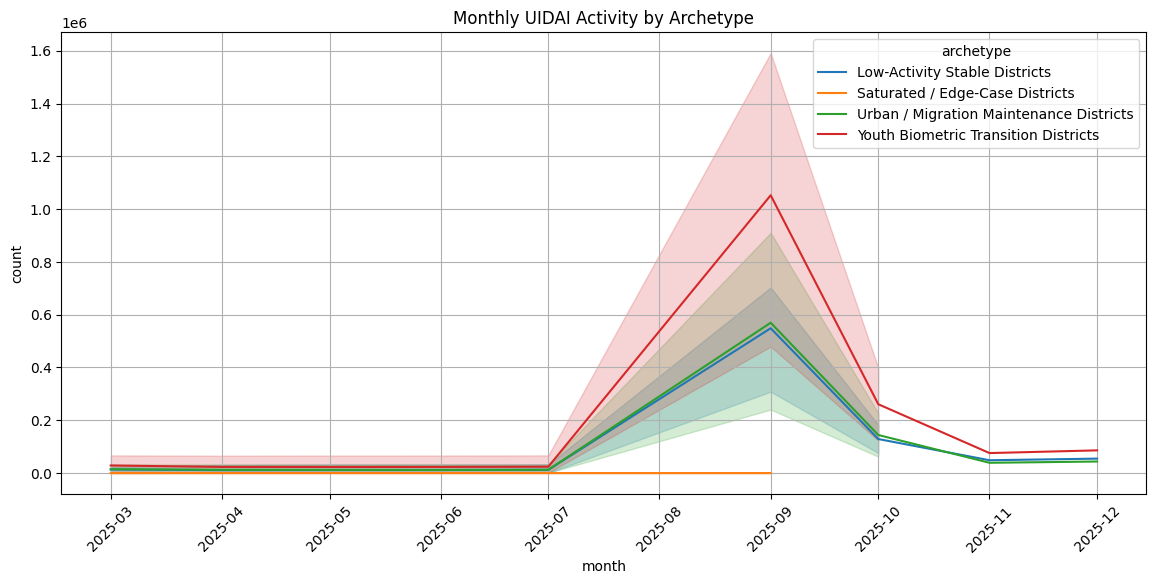

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Period to timestamp for plotting
monthly_archetype['month'] = monthly_archetype['month'].dt.to_timestamp()

plt.figure(figsize=(14,6))
sns.lineplot(
    data=monthly_archetype,
    x='month',
    y='count',
    hue='archetype',
    estimator='sum'
)
plt.title('Monthly UIDAI Activity by Archetype')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

A centrally coordinated, time-bound UIDAI operational drive occurred in September 2025, disproportionately impacting youth-dominant districts, with secondary spillovers into urban migration maintenance zones and forced compliance in low-activity regions.